In [35]:
#SOM网络pytorch实现
import numpy as np
c1 = np.array([1,1])
c2 = np.array([-1,-1])
c3 = np.array([1,-1])
c4 = np.array([-1,1])

In [36]:
x1 = c1 + np.random.random_sample([100,2])-1
x2 = c2 + np.random.random_sample([100,2])
x3 = c3 + np.random.random_sample([100,2])-1
x4 = c4 + np.random.random_sample([100,2])-1
x3[:,1] = x3[:,1] + 1
x4[:,0] = x4[:,0] + 1

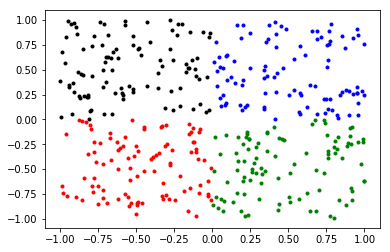

In [37]:
import matplotlib.pyplot as plt
plt.plot(x1[:,0],x1[:,1],'b.')
plt.plot(x2[:,0],x2[:,1],'r.')
plt.plot(x3[:,0],x3[:,1],'g.')
plt.plot(x4[:,0],x4[:,1],'k.')
plt.show()

In [38]:
x = np.concatenate((x1,x2,x3,x4))
label = np.concatenate((np.array([1]*100),np.array([2]*100),np.array([3]*100),np.array([4]*100)))

In [39]:
print(x.shape)
print(label.shape)

(400, 2)
(400,)


In [40]:
rng_state = np.random.get_state()
np.random.shuffle(x)
np.random.set_state(rng_state)
np.random.shuffle(label)

In [41]:
import torch
import torch.nn as nn
x = torch.FloatTensor(x)
y = torch.tensor(label)
print(x[1])

tensor([ 0.6824, -0.9177])


In [42]:
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)
def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [252]:
class SOM(nn.Module):
    """Model proposed in understanding beta-VAE paper(Burgess et al, arxiv:1804.03599, 2018)."""

    def __init__(self):
        super(SOM, self).__init__()
        self.SOM_layer = nn.Parameter(torch.rand(4,2))
        self.first = True
        self.weight_init()

    def weight_init(self):
        for w in self.SOM_layer:
            kaiming_init(w)
    def forward(self, x, y = None):
        if self.first is True:
            self.SOM_layer.data = torch.cat([x.mean(0).unsqueeze(0)]*4,dim=0)+0.1*torch.rand(4,2)
            self.first = False
        distance = [(((x-w)**2).sum(-1)**0.5).unsqueeze(-1) for w in self.SOM_layer]
        distance = torch.cat(distance,dim=-1)
        if y is None:
            _, index = distance.min(dim=1)
        else:
            index = y-1
        mask = Variable(torch.eye(4).index_select(dim=0, index=index.data))

        return mask, index

In [253]:
from torch.utils.data import Dataset, DataLoader
class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, label_tensor):
        self.data_tensor = data_tensor
        self.label_tensor = label_tensor

    def __getitem__(self, index):
        return self.data_tensor[index],self.label_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)
def return_data(it):
    return x[10*(it-1):it*10,:],y[10*(it-1):it*10]

In [255]:
from tqdm import tqdm
from torch.autograd import Variable
import torch.optim as optim
net = SOM()

def train():
    optimizer = optim.Adam(net.parameters(), lr=10e-4,
                                    betas=(0.9, 0.99))
    print("training start!!!")
    global_iter = 0
    it = 1
    pbar = tqdm(total=1000)
    pbar.update(global_iter)
    for i in range(1000):
        x_,y = return_data(it)
        pbar.update(1)
        if it == 10:
            it = 1
        else:
            it += 1
        global_iter += 1
        x_ = Variable(x_)
        y = Variable(y)
        mask, index = net(x_)
        cluster_loss = (torch.cat([(((x_-w)**2).sum(-1)).unsqueeze(-1) for w in net.SOM_layer],dim=-1)*mask).sum(1).mean(0)
        optimizer.zero_grad()
        cluster_loss.backward()
        optimizer.step()
    pbar.close()

In [256]:
x.shape

torch.Size([400, 2])

In [257]:
train()

training start!!!







  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]




 16%|████████████                                                                 | 157/1000 [00:00<00:00, 1565.87it/s]




 33%|█████████████████████████▎                                                   | 329/1000 [00:00<00:00, 1607.92it/s]




 50%|██████████████████████████████████████▊                                      | 504/1000 [00:00<00:00, 1646.83it/s]




 68%|████████████████████████████████████████████████████▋                        | 685/1000 [00:00<00:00, 1691.35it/s]




 87%|██████████████████████████████████████████████████████████████████▊          | 867/1000 [00:00<00:00, 1726.68it/s]




100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1725.52it/s]

In [258]:
print(net.SOM_layer)

Parameter containing:
tensor([[ 0.2974,  0.4295],
        [-0.6174, -0.3616],
        [ 0.3303, -0.5044],
        [-0.6791,  0.5775]], requires_grad=True)


In [259]:
t = Variable(x)

In [260]:
mask,index = net(t)

In [261]:
print(t)

tensor([[-0.8278, -0.0241],
        [ 0.6824, -0.9177],
        [-0.6851,  0.8486],
        [-0.9046,  0.9694],
        [ 0.1630, -0.5054],
        [-0.9428,  0.3229],
        [-0.0110, -0.8066],
        [-0.1697,  0.5600],
        [-0.7821, -0.7359],
        [-0.4868,  0.7081],
        [-0.1584,  0.5184],
        [-0.1585, -0.9237],
        [ 0.7563, -0.1593],
        [-0.3272, -0.0689],
        [-0.4920, -0.8587],
        [-0.7372, -0.2388],
        [-0.6846,  0.6307],
        [-0.5881,  0.2466],
        [-0.9577,  0.8292],
        [-0.5457, -0.8680],
        [-0.9637, -0.1503],
        [ 0.6216, -0.7430],
        [-0.2576,  0.0906],
        [ 0.9477,  0.9109],
        [-0.3584,  0.4710],
        [ 0.2038,  0.9495],
        [ 0.6540, -0.0466],
        [ 0.4316, -0.9174],
        [ 0.8259,  0.0187],
        [-0.2784,  0.9989],
        [-0.0420,  0.0783],
        [ 0.2860, -0.2770],
        [-0.0059, -0.4913],
        [ 0.1889,  0.8240],
        [ 0.7576,  0.1044],
        [-0.3518, -0

        [ 0.4210,  0.7316]])


In [262]:
print(net.SOM_layer.shape)
print(mask.shape)

torch.Size([4, 2])
torch.Size([400, 4])


In [263]:
torch.cat([(((t-w)**2).sum(-1)**0.5).unsqueeze(-1) for w in net.SOM_layer],dim=-1)*mask

tensor([[0.0000, 0.3977, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5430, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2711],
        ...,
        [0.0000, 0.0000, 0.0000, 0.4157],
        [0.0000, 0.5305, 0.0000, 0.0000],
        [0.3265, 0.0000, 0.0000, 0.0000]], grad_fn=<ThMulBackward>)

In [264]:
x.mean(0)

tensor([-0.0039,  0.0075])

In [265]:
distance = [(((t-w)**2).sum(-1)**0.5).unsqueeze(-1) for w in net.SOM_layer]
distance = torch.cat(distance,dim=-1)
_, index = distance.min(dim=1)

In [266]:
index

tensor([1, 2, 3, 3, 2, 3, 2, 0, 1, 3, 0, 2, 2, 1, 1, 1, 3, 3, 3, 1, 1, 2, 1, 0,
        3, 0, 2, 2, 0, 3, 0, 2, 2, 0, 0, 1, 3, 3, 0, 3, 0, 2, 3, 1, 3, 2, 3, 1,
        0, 0, 1, 0, 3, 2, 2, 3, 2, 0, 3, 3, 1, 1, 2, 1, 1, 0, 1, 0, 1, 2, 1, 0,
        1, 2, 3, 3, 0, 0, 1, 1, 3, 3, 3, 2, 2, 0, 1, 0, 2, 3, 0, 2, 3, 2, 0, 2,
        2, 3, 0, 0, 2, 2, 3, 3, 2, 1, 0, 0, 1, 0, 1, 3, 0, 2, 0, 2, 3, 3, 2, 2,
        0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 2, 3, 1, 1, 0, 3, 2, 2, 0, 0, 1, 3, 2, 2,
        0, 1, 0, 2, 3, 2, 1, 3, 1, 0, 3, 0, 2, 1, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0,
        0, 0, 0, 0, 2, 0, 0, 3, 0, 1, 3, 0, 0, 2, 1, 1, 2, 2, 1, 2, 3, 3, 2, 2,
        2, 1, 0, 1, 0, 3, 0, 2, 0, 3, 1, 2, 2, 0, 1, 2, 3, 1, 3, 0, 3, 0, 1, 2,
        1, 3, 0, 0, 1, 2, 2, 2, 3, 0, 0, 2, 0, 1, 0, 2, 2, 3, 2, 2, 0, 1, 0, 3,
        1, 3, 2, 3, 1, 3, 2, 3, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 0, 2, 0, 3,
        2, 2, 2, 0, 3, 3, 3, 1, 0, 1, 0, 0, 3, 2, 2, 2, 1, 2, 2, 0, 0, 0, 2, 2,
        0, 3, 0, 0, 1, 2, 1, 0, 1, 0, 0,

In [267]:
y.shape[0]

400

可以看到这里，基本上是0->4,2->1,3->3,1->2
的聚类结果

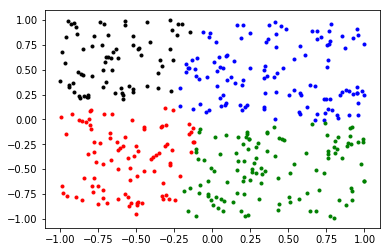

In [268]:
import matplotlib.pyplot as plt
for i in range(y.shape[0]):
    if index[i] == 0:
        plt.plot(x[i,0],x[i,1],'b.')
    elif index[i] == 1:
        plt.plot(x[i,0],x[i,1],'r.')
    elif index[i] == 2:
        plt.plot(x[i,0],x[i,1],'g.')
    else:
        plt.plot(x[i,0],x[i,1],'k.')
plt.show()